In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
import cv2
import glob
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil, floor
from tqdm import tqdm, tqdm_notebook
from skimage import morphology
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, ZeroPadding2D, Dense, Dropout, \
    Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import recall_score, roc_auc_score, f1_score, roc_curve, classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
base_data_dir = '../data/chest_xray/'

data_dir = base_data_dir + 'prepared/'
normal_dir = data_dir + 'normal/'
pneumonia_dir = data_dir + 'pneumonia/'
bacteria_dir = pneumonia_dir + 'bacteria/'
virus_dir = pneumonia_dir + 'virus/'
models_dir = './models/'
models_lungs_dir = models_dir + 'lung/'
models_binary_dir = models_dir + 'binary/'
models_categorical_dir = models_dir + 'categorical/'

for directory in [normal_dir, bacteria_dir, virus_dir, models_lungs_dir,
                  models_binary_dir, models_categorical_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

lung_segmentation_model_path = models_lungs_dir + 'lung_segmentation.hdf5'

In [3]:
normal_patterns = [
    base_data_dir + 'train/NORMAL/*.jpeg',
    base_data_dir + 'test/NORMAL/*.jpeg',
    base_data_dir + 'val/NORMAL/*.jpeg'
]

bacteria_patterns = [
    base_data_dir + 'train/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*bacteria*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*bacteria*.jpeg'
]

virus_patterns = [
    base_data_dir + 'train/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'test/PNEUMONIA/*virus*.jpeg',
    base_data_dir + 'val/PNEUMONIA/*virus*.jpeg'
]

raw_normal = [item for sublist in [glob.glob(path) for path in normal_patterns] for item in sublist]
raw_bacteria = [item for sublist in [glob.glob(path) for path in bacteria_patterns] for item in sublist]
raw_virus = [item for sublist in [glob.glob(path) for path in virus_patterns] for item in sublist]

In [4]:
get_file('lung_segmentation.hdf5',
         'https://raw.githubusercontent.com/imlab-uiip/lung-segmentation-2d/master/trained_model.hdf5',
         cache_dir = models_dir, cache_subdir = 'lung')

UNet = load_model(lung_segmentation_model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
def adjust_gamma(image, gamma = 1.0):
    invGamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


def adjust_contrast(image, contrast = 0):
    buf = image.copy()
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
    return buf


def normalize_image(original, target_width = 256):
    im_shape = (256, 256)
    original_width = original.shape[1]
    original_height = original.shape[0]

    width_coeff = 256 / original_width
    height_coeff = 256 / original_height

    img = cv2.resize(original, im_shape, interpolation = cv2.INTER_AREA)
    img = cv2.equalizeHist(img)
    img = adjust_gamma(img, 0.75)
    img = img * 1.2
    img = np.clip(img, 0, 255)

    img2 = img.astype(float)
    img2 -= img2.mean()
    img2 /= img2.std()

    img2 = np.expand_dims(img2, -1)
    inp_shape = img2.shape
    pred = UNet.predict([[img2]])[..., 0].reshape(inp_shape[:2])
    pr = pred > 0.5
    pr = remove_small_regions(pr, 0.01 * np.prod(im_shape))
    pr = pr.astype(int)

    non_empty_columns = np.where(pr.max(axis = 0) > 0)[0]
    non_empty_rows = np.where(pr.max(axis = 1) > 0)[0]
    left = min(non_empty_columns) if len(non_empty_columns) > 0 else 0
    right = max(non_empty_columns) if len(non_empty_columns) > 0 else 256
    top = min(non_empty_rows) if len(non_empty_rows) > 0 else 0
    bottom = max(non_empty_rows) if len(non_empty_rows) > 0 else 256

    if right < 256 / 1.9:
        right = 256 - left

    if left > 256 / 2.1:
        left = 256 - right

    l = floor(left / width_coeff)
    t = floor(top / height_coeff)
    w = floor((right - left) / width_coeff)
    h = floor((bottom - top) / height_coeff)

    cropped = original[t:t + h, l:l + w]
    resized = cv2.resize(cropped, (target_width, target_width), interpolation = cv2.INTER_AREA)
    equalized = cv2.equalizeHist(resized)
    return equalized


def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [6]:
image_width = 256

i = 0
for path in tqdm_notebook(raw_normal):
    output_path = normal_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

i = 0
for path in tqdm_notebook(raw_bacteria + raw_virus):
    if 'bacteria' in path:
        output_path = bacteria_dir + '{0:04d}.jpeg'.format(i)
    else:
        output_path = virus_dir + '{0:04d}.jpeg'.format(i)
    if not os.path.exists(output_path):
        img = cv2.imread(path, 0)
        normalized = normalize_image(img, image_width)
        cv2.imwrite(output_path, normalized)
    i += 1

In [77]:
normal_df = pd.DataFrame(
    {'path': glob.glob(normal_dir + '*.jpeg'), 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
bacteria_df = pd.DataFrame(
    {'path': glob.glob(bacteria_dir + '*.jpeg'), 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
virus_df = pd.DataFrame(
    {'path': glob.glob(virus_dir + '*.jpeg'), 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

# normal_df = pd.DataFrame(
#     {'path': raw_normal, 'normal': 1, 'bacteria': 0, 'virus': 0, 'target': 'Normal'})
# bacteria_df = pd.DataFrame(
#     {'path': raw_bacteria, 'normal': 0, 'bacteria': 1, 'virus': 0, 'target': 'Pneumonia'})
# virus_df = pd.DataFrame(
#     {'path': raw_virus, 'normal': 0, 'bacteria': 0, 'virus': 1, 'target': 'Pneumonia'})

dataset = pd.concat([normal_df, bacteria_df, virus_df])
dataset = dataset.sort_values('path')
dataset = dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [78]:
pd.set_option('max_colwidth', 100)
dataset.head(10)

,path,normal,bacteria,virus,target
0,../data/chest_xray/prepared/pneumonia/bacteria/2448.jpeg,0,1,0,Pneumonia
1,../data/chest_xray/prepared/pneumonia/bacteria/0207.jpeg,0,1,0,Pneumonia
2,../data/chest_xray/prepared/normal/0608.jpeg,1,0,0,Normal
3,../data/chest_xray/prepared/pneumonia/virus/4160.jpeg,0,0,1,Pneumonia
4,../data/chest_xray/prepared/pneumonia/virus/4161.jpeg,0,0,1,Pneumonia
5,../data/chest_xray/prepared/pneumonia/bacteria/1984.jpeg,0,1,0,Pneumonia
6,../data/chest_xray/prepared/normal/1045.jpeg,1,0,0,Normal
7,../data/chest_xray/prepared/pneumonia/virus/3815.jpeg,0,0,1,Pneumonia
8,../data/chest_xray/prepared/normal/0642.jpeg,1,0,0,Normal
9,../data/chest_xray/prepared/pneumonia/bacteria/1023.jpeg,0,1,0,Pneumonia


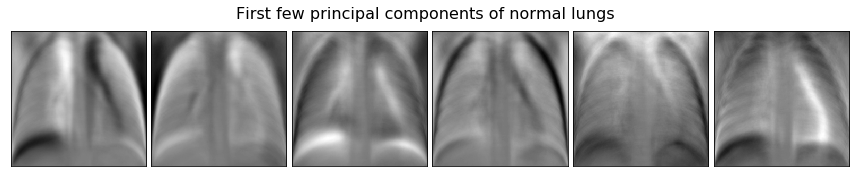

One can even clearly observe bronchus system in few most significant components of normal lungs


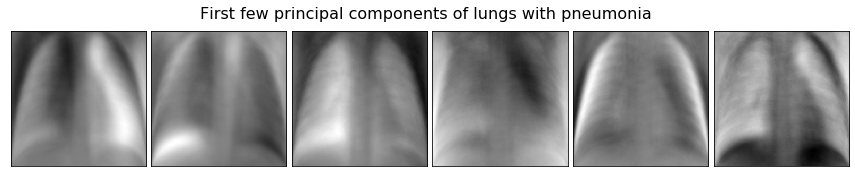

Pleural effusions and airspace consolidation in the different parts of the lungs with pneumonia make few first principal components a bit blurred


In [79]:
number_of_images = 1500
n_row, n_col = 1, 6
n_components = n_row * n_col

pca = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True)


def plot_gallery(title, images, n_col = n_col, n_row = n_row, cmap = plt.cm.gray):
    plt.figure(figsize = (2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size = 16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(256, 256), cmap = cmap,
                   interpolation = 'nearest',
                   vmin = -vmax, vmax = vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.02, -0.1, 0.99, 0.93, 0.04, 0.)


few_normal_images = np.array([cv2.imread(path, 0).flatten() for path in normal_df.head(number_of_images).path])
pca.fit(few_normal_images)
plot_gallery('First few principal components of normal lungs', pca.components_[:n_components])
plt.show()

print('One can even clearly observe bronchus system in few most significant components of normal lungs')

pneumonia_df = pd.concat([bacteria_df, virus_df]).sample(frac = 1, random_state = 0).reset_index(drop = True)
few_pneumonia_images = np.array([cv2.imread(path, 0).flatten() for path in pneumonia_df.head(number_of_images).path])
pca.fit(few_pneumonia_images)
plot_gallery('First few principal components of lungs with pneumonia', pca.components_[:n_components])
plt.show()

print(
    'Pleural effusions and airspace consolidation in the different parts of the lungs with pneumonia make few first principal components a bit blurred')

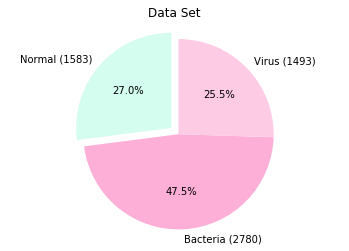

In [80]:
colors = ['#D4FCEF', '#FDAFD7', '#FECBE5']


def labels(normal_amount, bacteria_amount, virus_amount): return \
    'Normal ({0:d})'.format(normal_amount), \
    'Bacteria ({0:d})'.format(bacteria_amount), \
    'Virus ({0:d})'.format(virus_amount)


def sizes(normal_amount, bacteria_amount, virus_amount):
    total = normal_amount + bacteria_amount + virus_amount
    return [normal_amount / total, bacteria_amount / total, virus_amount / total]


fig1, ax1 = plt.subplots()
ax1.pie(sizes(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        explode = (0.1, 0, 0), labels = labels(normal_df.shape[0], bacteria_df.shape[0], virus_df.shape[0]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Data Set')
plt.show()

## Normal vs Pneumonia Binary Classification

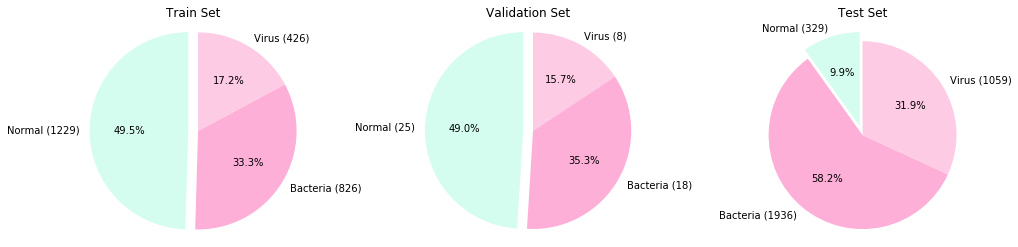

In [81]:
test_size = 0.2
validation_size = 0.02

sampler = RandomUnderSampler(random_state = 0)
X_balanced, _ = sampler.fit_resample(dataset[['path']].values, dataset[['target']].values)

balanced_dataset = pd.DataFrame({'path': X_balanced[:, 0]})
balanced_dataset = balanced_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
balanced_dataset = pd.merge(balanced_dataset, dataset, on = 'path')
rest_dataset = pd.DataFrame(
    {'path': list(set(X_balanced[:, 0].tolist()).symmetric_difference(dataset[['path']].values[:, 0].tolist()))})
rest_dataset = rest_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
rest_dataset = pd.merge(rest_dataset, dataset, on = 'path')

X_train_validation, X_test, y_train_validation, _ = train_test_split(
    balanced_dataset.path.values, balanced_dataset.target.values,
    test_size = test_size, random_state = 0)
X_train, X_validation, _, _ = train_test_split(
    X_train_validation, y_train_validation,
    test_size = validation_size, random_state = 3)

train_dataset = pd.merge(pd.DataFrame({'path': X_train}), dataset, on = 'path')
validation_dataset = pd.merge(pd.DataFrame({'path': X_validation}), dataset, on = 'path')
test_dataset = pd.concat([pd.merge(pd.DataFrame({'path': X_test}), dataset, on = 'path'), rest_dataset])

fig = plt.figure(figsize = (17, 4))
ax1 = fig.add_subplot(131)
ax1.pie(sizes(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(train_dataset.sum()[1], train_dataset.sum()[2], train_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Train Set')

ax3 = fig.add_subplot(132)
ax3.pie(sizes(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        explode = (0.1, 0, 0),
        labels = labels(validation_dataset.sum()[1], validation_dataset.sum()[2], validation_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax3.axis('equal')
ax3.title.set_text('Validation Set')

ax2 = fig.add_subplot(133)
ax2.pie(sizes(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(test_dataset.sum()[1], test_dataset.sum()[2], test_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax2.axis('equal')
ax2.title.set_text('Test Set')

plt.show()

In [31]:
imageGenerator = ImageDataGenerator(rescale = 1. / 255, horizontal_flip = True)
testGenerator = ImageDataGenerator(rescale = 1. / 255)

batch_size = 4
x_col = 'path'
y_col = 'target'
classes = ['Normal', 'Pneumonia']
mode = 'grayscale'
target_size = (150, 150)

print('Train generator:')
train_generator = imageGenerator.flow_from_dataframe(train_dataset, x_col = x_col, y_col = y_col,
                                                     seed = 0, target_size = target_size, batch_size = batch_size,
                                                     class_mode = 'binary', color_mode = mode)

print('\nValidation generator:')
validation_generator = testGenerator.flow_from_dataframe(validation_dataset, x_col = x_col, y_col = y_col,
                                                         seed = 0, target_size = target_size, batch_size = batch_size,
                                                         class_mode = 'binary', color_mode = mode, shuffle = False)

print('\nTest generator:')
test_generator = testGenerator.flow_from_dataframe(test_dataset, x_col = x_col, y_col = y_col,
                                                   seed = 0, target_size = target_size, batch_size = 1,
                                                   class_mode = 'binary', color_mode = mode, shuffle = False)

Train generator:
Found 2481 validated image filenames belonging to 2 classes.

Validation generator:
Found 51 validated image filenames belonging to 2 classes.

Test generator:
Found 3324 validated image filenames belonging to 2 classes.


In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.15))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.15))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
___________________________

In [14]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


model_check_point = ModelCheckpoint(
    models_binary_dir + 'pneumonia-{val_loss:.2f}-{val_acc:.2f}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    save_best_only = True, verbose = 1, monitor = 'val_acc', mode = 'max')

In [15]:
optimizer = Adam()

model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
              metrics = ['accuracy', recall, precision])

train_generator.reset()
validation_generator.reset()
history = model.fit_generator(epochs = 100, shuffle = True, validation_data = validation_generator,
                              steps_per_epoch = 100, generator = train_generator,
                              validation_steps = validation_dataset.shape[0] * batch_size,
                              verbose = 1, callbacks = [model_check_point])

Epoch 1/100
100/100 [==============================] - 21s 209ms/step - loss: 0.5725 - acc: 0.7225 - recall: 0.7025 - precision: 0.7100 - val_loss: 0.9913 - val_acc: 0.5680 - val_recall: 0.7574 - val_precision: 0.5148

Epoch 00001: val_acc improved from -inf to 0.56804, saving model to ./models/binary/pneumonia-0.99-0.57-0.51-0.76.hdf5
Epoch 2/100
100/100 [==============================] - 22s 224ms/step - loss: 0.5065 - acc: 0.7800 - recall: 0.7658 - precision: 0.7758 - val_loss: 0.7175 - val_acc: 0.7300 - val_recall: 0.6317 - val_precision: 0.6883

Epoch 00002: val_acc improved from 0.56804 to 0.73000, saving model to ./models/binary/pneumonia-0.72-0.73-0.69-0.63.hdf5
Epoch 3/100
100/100 [==============================] - 21s 210ms/step - loss: 0.4143 - acc: 0.8125 - recall: 0.8050 - precision: 0.8408 - val_loss: 0.6472 - val_acc: 0.7037 - val_recall: 0.3275 - val_precision: 0.5500

Epoch 00003: val_acc did not improve from 0.73000
Epoch 4/100
100/100 [==============================]

100/100 [==============================] - 21s 207ms/step - loss: 0.2137 - acc: 0.9050 - recall: 0.8508 - precision: 0.8550 - val_loss: 0.2429 - val_acc: 0.8850 - val_recall: 0.8250 - val_precision: 0.7758

Epoch 00058: val_acc did not improve from 0.94125
Epoch 59/100
100/100 [==============================] - 21s 206ms/step - loss: 0.2327 - acc: 0.9050 - recall: 0.8342 - precision: 0.8483 - val_loss: 0.3236 - val_acc: 0.8614 - val_recall: 0.7973 - val_precision: 0.7853

Epoch 00059: val_acc did not improve from 0.94125
Epoch 60/100
100/100 [==============================] - 21s 206ms/step - loss: 0.1957 - acc: 0.9225 - recall: 0.8792 - precision: 0.8858 - val_loss: 0.2364 - val_acc: 0.9038 - val_recall: 0.7208 - val_precision: 0.7583

Epoch 00060: val_acc did not improve from 0.94125
Epoch 61/100
100/100 [==============================] - 21s 207ms/step - loss: 0.1719 - acc: 0.9300 - recall: 0.8350 - precision: 0.8483 - val_loss: 0.2906 - val_acc: 0.8838 - val_recall: 0.7200 - val_pr

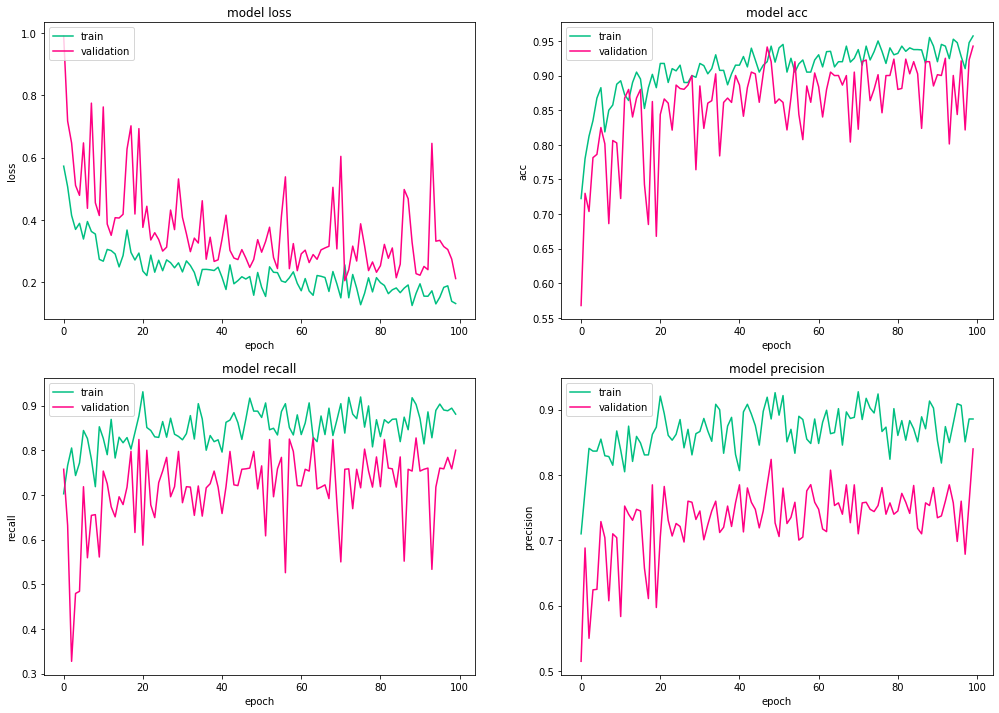

In [16]:
metrics = ['loss', 'acc', 'recall', 'precision']

fig = plt.figure(figsize = (17, 12))
for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_facecolor('w')
    ax.grid(b = False)
    ax.plot(history.history[metric], color = '#00bf81')
    ax.plot(history.history['val_' + metric], color = '#ff0083')
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')

plt.show()

In [131]:
binary_models = []
for model_path in glob.glob(models_binary_dir + 'pneumonia-*.hdf5'):
    name = os.path.basename(model_path)
    (prefix, sep, suffix) = name.rpartition('.')
    scores = list(map(lambda k: float(k), prefix.split('-')[1:]))
    binary_models.append([model_path] + scores)

binary_models = pd.DataFrame(binary_models, columns = ['path', 'loss', 'acc', 'precision', 'recall'])

# sorted_models = binary_models.sort_values(['acc', 'loss'], ascending = [False, True])
sorted_models = binary_models.sort_values(['acc', 'precision'], ascending = [False, False])

best_binary_model_path = sorted_models.path.iloc[0]
print('Best binary model:', best_binary_model_path)

Best binary model: ./models/binary/pneumonia-0.21-0.94-0.84-0.80.hdf5


In [23]:
best_binary_model = load_model(best_binary_model_path, custom_objects = {
    'recall': recall,
    'precision': precision
})

In [24]:
test_generator.reset()
test_pred = best_binary_model.predict_generator(test_generator, verbose = 1, steps = test_dataset.shape[0])

3324/3324 [==============================] - 27s 8ms/step


In [155]:
print(classification_report(test_generator.classes, np.rint(test_pred).astype(int).flatten(), target_names = classes))

              precision    recall  f1-score   support

      Normal       0.66      0.94      0.78       329
   Pneumonia       0.99      0.95      0.97      2995

    accuracy                           0.95      3324
   macro avg       0.83      0.94      0.87      3324
weighted avg       0.96      0.95      0.95      3324



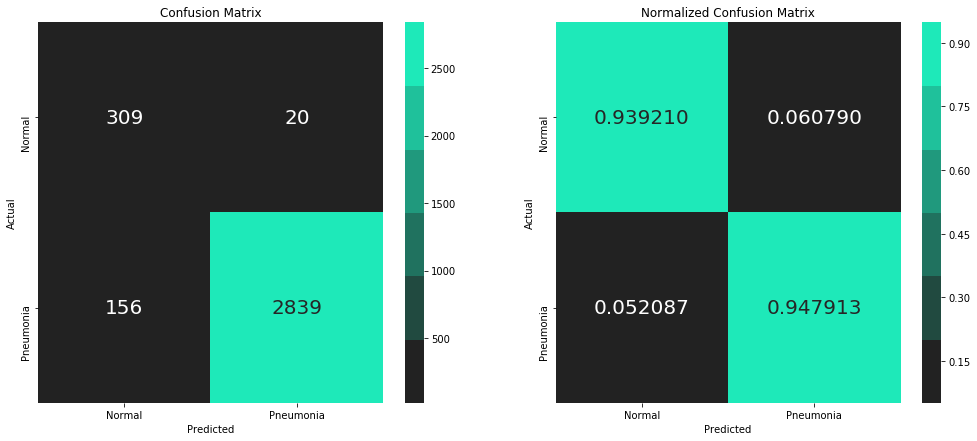

In [61]:
cm = confusion_matrix(y_true = test_generator.classes, y_pred = np.rint(test_pred).astype(int).flatten().tolist())
ncm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

fig = plt.figure(figsize = (17, 7))

ax = plt.subplot(1, 2, 1)
sns.heatmap(cm, annot = True, annot_kws = {"size": 20}, ax = ax, fmt = 'd',
            cmap = sns.dark_palette((30 / 256, 234 / 256, 186 / 256), input = "rgb"))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

ax = plt.subplot(1, 2, 2)
sns.heatmap(ncm, annot = True, annot_kws = {"size": 20}, ax = ax, fmt = 'f',
            cmap = sns.dark_palette((30 / 256, 234 / 256, 186 / 256), input = "rgb"))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.show()

## Normal vs Bacterial Pneumonia vs Viral Pneumonia Classification

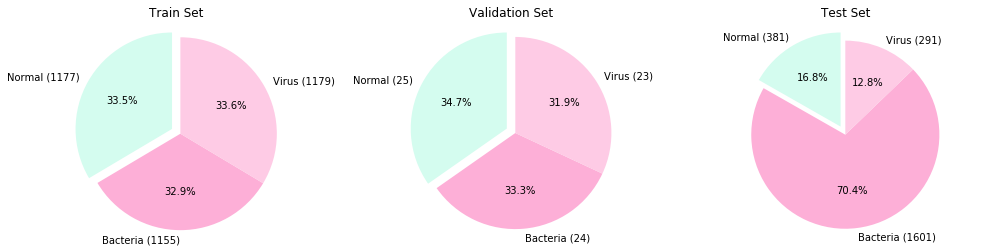

In [121]:
test_size = 0.2
validation_size = 0.02

multi_class_dataset = dataset.copy()
multi_class_dataset['target'] = multi_class_dataset.apply(
    lambda row: 'Normal' if row['normal'] == 1 else 'Bacterial' if row['bacteria'] == 1 else 'Viral', axis = 1)

sampler = RandomUnderSampler(random_state = 0)
X_balanced, _ = sampler.fit_resample(multi_class_dataset[['path']].values, multi_class_dataset[['target']].values)

balanced_multi_class_dataset = pd.DataFrame({'path': X_balanced[:, 0]})
balanced_multi_class_dataset = balanced_multi_class_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
balanced_multi_class_dataset = pd.merge(balanced_multi_class_dataset, multi_class_dataset, on = 'path')

rest_multi_class_dataset = pd.DataFrame(
    {'path': list(
        set(X_balanced[:, 0].tolist()).symmetric_difference(multi_class_dataset[['path']].values[:, 0].tolist()))})
rest_multi_class_dataset = rest_multi_class_dataset.sample(frac = 1, random_state = 0).reset_index(drop = True)
rest_multi_class_dataset = pd.merge(rest_multi_class_dataset, multi_class_dataset, on = 'path')

X_train_validation, X_test, y_train_validation, _ = train_test_split(
    balanced_multi_class_dataset.path.values, balanced_multi_class_dataset.target.values,
    test_size = test_size, random_state = 3)

X_train, X_validation, _, _ = train_test_split(
    X_train_validation, y_train_validation,
    test_size = validation_size, random_state = 2)

train_multi_class_dataset = pd.merge(pd.DataFrame({'path': X_train}), multi_class_dataset, on = 'path')
validation_multi_class_dataset = pd.merge(pd.DataFrame({'path': X_validation}), multi_class_dataset, on = 'path')
test_multi_class_dataset = pd.concat(
    [pd.merge(pd.DataFrame({'path': X_test}), multi_class_dataset, on = 'path'), rest_multi_class_dataset])

fig = plt.figure(figsize = (17, 4))
ax1 = fig.add_subplot(131)
ax1.pie(
    sizes(train_multi_class_dataset.sum()[1], train_multi_class_dataset.sum()[2], train_multi_class_dataset.sum()[3]),
    explode = (0.1, 0, 0), labels = labels(train_multi_class_dataset.sum()[1], train_multi_class_dataset.sum()[2],
                                           train_multi_class_dataset.sum()[3]),
    autopct = '%1.1f%%', startangle = 90, colors = colors)
ax1.axis('equal')
ax1.title.set_text('Train Set')

ax3 = fig.add_subplot(132)
ax3.pie(sizes(validation_multi_class_dataset.sum()[1], validation_multi_class_dataset.sum()[2],
              validation_multi_class_dataset.sum()[3]),
        explode = (0.1, 0, 0),
        labels = labels(validation_multi_class_dataset.sum()[1], validation_multi_class_dataset.sum()[2],
                        validation_multi_class_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax3.axis('equal')
ax3.title.set_text('Validation Set')

ax2 = fig.add_subplot(133)
ax2.pie(sizes(test_multi_class_dataset.sum()[1], test_multi_class_dataset.sum()[2], test_multi_class_dataset.sum()[3]),
        explode = (0.1, 0, 0), labels = labels(test_multi_class_dataset.sum()[1], test_multi_class_dataset.sum()[2],
                                               test_multi_class_dataset.sum()[3]),
        autopct = '%1.1f%%', startangle = 90, colors = colors)
ax2.axis('equal')
ax2.title.set_text('Test Set')

plt.show()

In [157]:
imageGenerator = ImageDataGenerator(rescale = 1. / 255, horizontal_flip = True)
testGenerator = ImageDataGenerator(rescale = 1. / 255)

batch_size = 4
x_col = 'path'
y_col = 'target'
multi_classes = ['Normal', 'Bacterial', 'Viral']
mode = 'grayscale'
target_size = (150, 150)

print('Train generator:')
train_multi_class_generator = imageGenerator.flow_from_dataframe(train_multi_class_dataset, x_col = x_col,
                                                                 y_col = y_col, classes = multi_classes,
                                                                 seed = 0, target_size = target_size,
                                                                 batch_size = batch_size,
                                                                 class_mode = 'categorical', color_mode = mode)

print('\nValidation generator:')
validation_multi_class_generator = testGenerator.flow_from_dataframe(validation_multi_class_dataset, x_col = x_col,
                                                                     y_col = y_col, classes = multi_classes,
                                                                     seed = 0, target_size = target_size,
                                                                     batch_size = batch_size,
                                                                     class_mode = 'categorical', color_mode = mode,
                                                                     shuffle = False)

print('\nTest generator:')
test_multi_class_generator = testGenerator.flow_from_dataframe(test_multi_class_dataset, x_col = x_col, y_col = y_col,
                                                               seed = 0, target_size = target_size, batch_size = 1,
                                                               class_mode = 'categorical', color_mode = mode,
                                                               shuffle = False, classes = multi_classes)

Train generator:
Found 3511 validated image filenames belonging to 3 classes.

Validation generator:
Found 72 validated image filenames belonging to 3 classes.

Test generator:
Found 2273 validated image filenames belonging to 3 classes.


In [158]:
multi_class_model = Sequential()

multi_class_model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(64, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(128, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(128, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))
multi_class_model.add(BatchNormalization())
multi_class_model.add(Dropout(rate = 0.15))

multi_class_model.add(Conv2D(128, (3, 3), activation = 'relu'))
multi_class_model.add(MaxPooling2D((2, 2)))

multi_class_model.add(GlobalAveragePooling2D())
multi_class_model.add(Dense(64, activation = 'relu'))
multi_class_model.add(Dropout(0.15))

multi_class_model.add(Dense(128, activation = 'relu'))
multi_class_model.add(Dropout(0.15))
multi_class_model.add(Dense(len(multi_classes), activation = 'softmax'))

multi_class_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 36, 36, 64)        256       
__________

In [159]:
multi_class_model_check_point = ModelCheckpoint(
    models_categorical_dir + 'pneumonia-{val_loss:.2f}-{val_acc:.2f}-{val_precision:.2f}-{val_recall:.2f}.hdf5',
    save_best_only = True, verbose = 1, monitor = 'val_acc', mode = 'max')

In [160]:
multi_class_optimizer = Adam()

multi_class_model.compile(loss = 'categorical_crossentropy', optimizer = multi_class_optimizer,
                          metrics = ['accuracy', recall, precision])

train_multi_class_generator.reset()
validation_multi_class_generator.reset()
multi_class_history = multi_class_model.fit_generator(epochs = 100, shuffle = True, 
                                          validation_data = validation_multi_class_generator,
                                          steps_per_epoch = 100, 
                                          generator = train_multi_class_generator,
                                          validation_steps = validation_multi_class_dataset.shape[0] * batch_size,
                                          verbose = 1, callbacks = [multi_class_model_check_point])

Epoch 1/20
 22/100 [=====>........................] - ETA: 19s - loss: 1.2096 - acc: 0.3636 - recall: 0.2386 - precision: 0.3371

KeyboardInterrupt: 

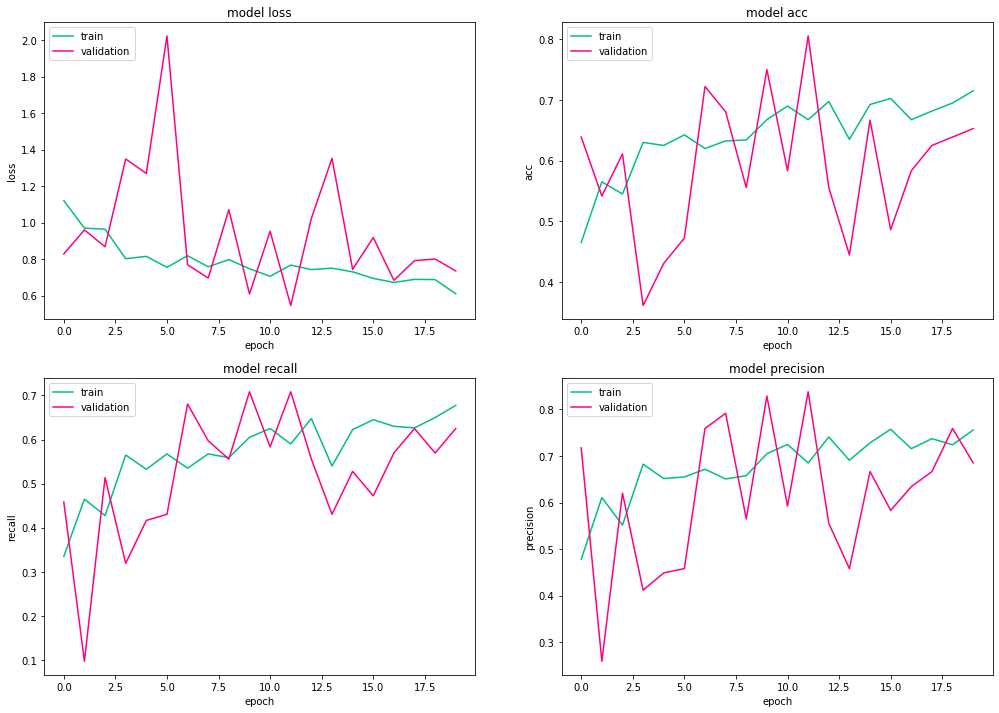

In [130]:
metrics = ['loss', 'acc', 'recall', 'precision']

fig = plt.figure(figsize = (17, 12))
for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_facecolor('w')
    ax.grid(b = False)
    ax.plot(multi_class_history.history[metric], color = '#00bf81')
    ax.plot(multi_class_history.history['val_' + metric], color = '#ff0083')
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')

plt.show()

In [133]:
categorical_models = []
for model_path in glob.glob(models_categorical_dir + 'pneumonia-*.hdf5'):
    name = os.path.basename(model_path)
    (prefix, sep, suffix) = name.rpartition('.')
    scores = list(map(lambda k: float(k), prefix.split('-')[1:]))
    categorical_models.append([model_path] + scores)

categorical_models = pd.DataFrame(categorical_models, columns = ['path', 'loss', 'acc', 'precision', 'recall'])

# sorted_models = categorical_models.sort_values(['acc', 'loss'], ascending = [False, True])
sorted_models = categorical_models.sort_values(['acc', 'precision'], ascending = [False, False])

best_categorical_model_path = sorted_models.path.iloc[0]
print('Best categorical model:', best_categorical_model_path)

Best categorical model: ./models/categorical/pneumonia-0.55-0.81-0.84-0.71.hdf5


In [134]:
best_categorical_model = load_model(best_categorical_model_path, custom_objects = {
    'recall': recall,
    'precision': precision
})

In [135]:
test_multi_class_generator.reset()
test_multi_class_pred = best_categorical_model.predict_generator(test_multi_class_generator, verbose = 1, steps = test_multi_class_dataset.shape[0])

2273/2273 [==============================] - 20s 9ms/step


In [145]:
print(test_multi_class_generator.classes[:100])

[2, 0, 0, 0, 2, 2, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 0]


In [141]:
print(np.argmax(test_multi_class_pred, axis = 1).tolist()[:100])

[1, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 0]


In [151]:
print(classification_report(test_multi_class_generator.classes, np.argmax(test_multi_class_pred, axis = 1), target_names=multi_classes))

              precision    recall  f1-score   support

      Normal       0.90      0.80      0.85      1601
   Bacterial       0.73      0.83      0.77       381
       Viral       0.34      0.50      0.41       291

    accuracy                           0.76      2273
   macro avg       0.66      0.71      0.68      2273
weighted avg       0.80      0.76      0.78      2273

